In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable
from matplotlib import lines
import matplotlib.cm as cm
import tqdm
from tqdm.notebook import tqdm as tqdm
import multiprocessing as mproc
import os
import random

import model_opt
import data_generate
import algo_GD

_cmap = plt.cm.jet


In [2]:
w_init = np.array([3,3])
_t_max = 10000
f = model_opt.RosenBrock(err = 0)

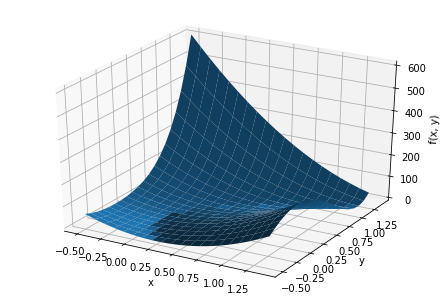

In [3]:
# RosenBrockの形状、最小値は[1,1]
x = np.arange(-0.5, 1.5, 0.1)
y = np.arange(-0.5, 1.5, 0.1)
X, Y = np.meshgrid(x, y)
Z = f.f_opt([X,Y])
fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x, y)")

ax.plot_surface(Y, X, Z)
plt.show()

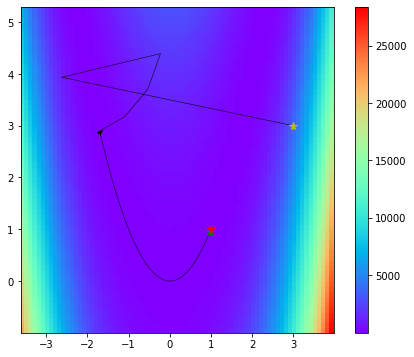

In [4]:
# エラーなしのRosenBrockのSGD

algo = algo_GD.SGD(w_init=w_init,t_max=_t_max,a=0.00078)
w_star = f.w_star

for i in tqdm(algo):
    algo.update(model=f)
    
w_store = np.array(algo.wstore)
grid_x_min = min(w_store.T[0].min(),w_star[0])-1
grid_x_max = max(w_store.T[0].max(),w_star[0])+1
grid_y_min = min(w_store.T[1].min(),w_star[1])-1
grid_y_max = max(w_store.T[1].max(),w_star[1])+1
xvals = np.arange(grid_x_min,grid_x_max, 0.1)
yvals = np.arange(grid_y_min,grid_y_max, 0.1)
X, Y = np.meshgrid(xvals, yvals)
Z = f.f_opt([X,Y])

fig, axes = plt.subplots(1,1, figsize=(6,6))
axes.pcolor(X, Y, Z,cmap=plt.cm.rainbow)
# wの軌跡
axes.plot(w_store.T[0],w_store.T[1],c = "k",alpha=1,linewidth = 0.5)
# 始点(黄色)、終点（緑）、真値（赤）
axes.plot(*w_store[0], 'y*', markersize=8)
axes.plot(*w_store[-1], 'g*', markersize=8)
axes.plot(*w_star, 'r*', markersize=8)

#カラーバーの設定
axpos = axes.get_position()
cbar_ax = fig.add_axes([0.9, axpos.y0, 0.03, axpos.height])
norm = colors.Normalize(vmin=Z.min(),vmax=Z.max())
mappable = ScalarMappable(cmap=plt.cm.rainbow,norm=norm)
mappable._A = []
fig.colorbar(mappable, cax=cbar_ax)

#余白の調整
plt.subplots_adjust(right=0.85)
plt.subplots_adjust(wspace=0.1)

plt.show()

In [5]:
# multiprocessの部分がnotebookでしか動かないため(if __name__ == "__main__":)　一旦関数をベタ書き
# マシンのコア数で並列処理
# コア間の統合を行う。
w_init = np.array([3,3])
_t_max = 5000
f = model_opt.RosenBrock(err = 1000)

def SGD_update(w):
    # エラーはerr * [0.0,1.0)の一様分布(numpy) * [0.0,1.0)の一様分布（Python標準モジュール）
    #  標準モジュールのランダム関数を用いないとコア間で全く同じノイスが載ってしまう。
    # :TODO ノイズについて修正必要
    f = model_opt.RosenBrock(err = 1000)
    algo = algo_GD.SGD(w_init=w,t_max=_t_max,a=0.0007)
    for i in algo:
        algo.update(model=f)
    return algo.wstore


    

if __name__ == "__main__":
    
    # 自分のマシンでコアが４つ
    cpu_count = mproc.cpu_count()
    
    # 同じ初期値でスタート
    w = np.tile(w_init,(cpu_count, 1))

    mypool = mproc.Pool(cpu_count)
    
    
    
    first_result = np.array(mypool.map(func=SGD_update, iterable=w))
    # ステップ数半分のところでwを全てのコアの平均に更新
    w = np.mean(first_result[:,-1],axis=0)    
    w = np.full((cpu_count, 2), w)
    second_result = np.array(mypool.map(func=SGD_update, iterable=w))
    # 最終１０ステップをコアの候補とし全コアの平均を最終結果とする
    process_result = np.mean(second_result[:,-10:],axis=1)
    last_result = np.mean(process_result,axis=0)

    # Memory management.
    mypool.close() # important for stopping memory leaks.
    mypool.join() # wait for all workers to exit.

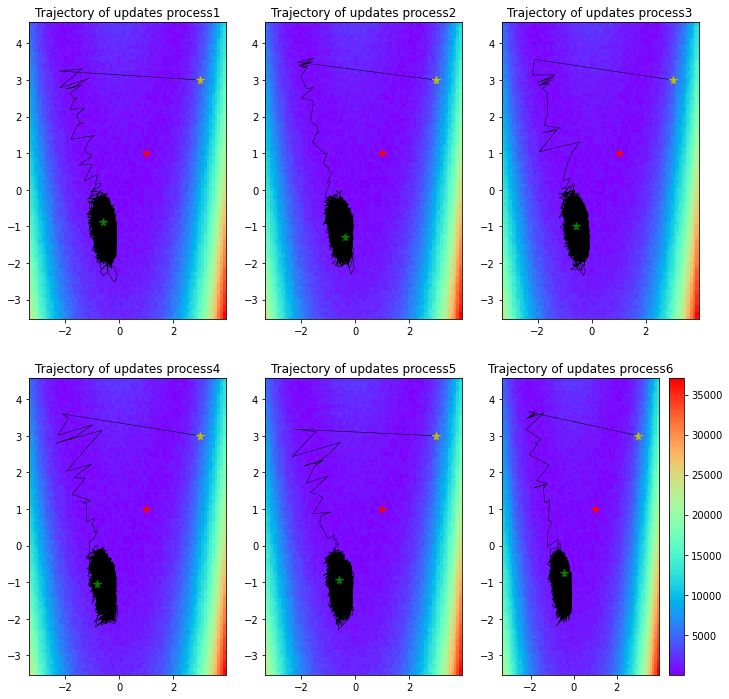

In [6]:
# 目的関数の真の値
w_star = f.w_star
w_store = np.concatenate([first_result,second_result],axis=1)
shape = w_store.shape
k = np.reshape(w_store,(2,-1,shape[1],shape[2]))




xvals = np.arange(k[:,:,:,0].min()-1,k[:,:,:,0].max()+1, 0.1)
yvals = np.arange(k[:,:,:,1].min()-1,k[:,:,:,1].max()+1, 0.1)
X, Y = np.meshgrid(xvals, yvals)
Z = f.f_opt([X,Y])

fig, axes = plt.subplots(k.shape[0],k.shape[1] , figsize=(12,12))
for i,value1 in enumerate(k):
    for j,value2 in enumerate(value1):
        
        axes[i][j].set_title("Trajectory of updates process{}".format(k.shape[1]*i + j + 1))
        axes[i][j].pcolor(X, Y, Z,cmap=plt.cm.rainbow)
        # wの軌跡
        axes[i][j].plot(value2.T[0],value2.T[1],c = "k",alpha=1,linewidth = 0.5)
        # 始点、終点、真値
        axes[i][j].plot(*value2[0], 'y*', markersize=8)
        axes[i][j].plot(*value2[-1], 'g*', markersize=8)
        axes[i][j].plot(*w_star, 'r*', markersize=8)

        
norm = colors.Normalize(vmin=Z.min(),vmax=Z.max())
mappable = ScalarMappable(cmap=plt.cm.rainbow,norm=norm)
fig.colorbar(mappable)



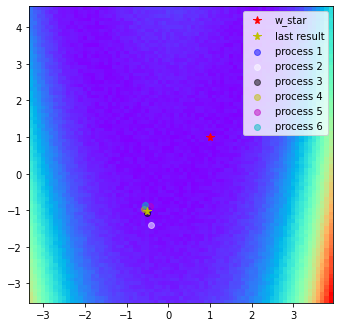

In [7]:
ten_colors = list(colors.BASE_COLORS.keys())
xvals = np.arange(k[:,:,:,0].min()-1,k[:,:,:,0].max()+1, 0.1)
yvals = np.arange(k[:,:,:,1].min()-1,k[:,:,:,1].max()+1, 0.1)
X, Y = np.meshgrid(xvals, yvals)
Z = f.f_opt([X,Y])

myfig = plt.figure(figsize=(12,12))
ax1 = myfig.add_subplot(2,2,1)
ax1.pcolor(X, Y, Z,cmap=plt.cm.rainbow)
ax1.plot(*w_star, 'r*', markersize=8,label="w_star")
for i,value in enumerate(process_result):
    ax1.scatter(*value, c=ten_colors[-i],label="process {}".format(i+1),alpha=0.5)
ax1.plot(*last_result, 'y*', markersize=8,label="last result")

ax1.legend()